<a href="https://colab.research.google.com/github/ishitavarshney/Object-detection-capstone/blob/master/capstone.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Setup

In [1]:
# Support for TF2 models was added after TF 2.3.
!pip install tf-nightly

In [2]:
import os
import pathlib

# Clone the tensorflow models repository if it doesn't already exist
if "models" in pathlib.Path.cwd().parts:
  while "models" in pathlib.Path.cwd().parts:
    os.chdir('..')
elif not pathlib.Path('models').exists():
  !git clone --depth 1 https://github.com/tensorflow/models

In [3]:
# Install the Object Detection API
%%bash
cd models/research/
protoc object_detection/protos/*.proto --python_out=.
cp object_detection/packages/tf2/setup.py .
python -m pip install .

Processing /content/models/research
  Created wheel for object-detection: filename=object_detection-0.1-cp36-none-any.whl size=1606783 sha256=a1dd1feebac40d71a8ac428cfc63fa7d8c96e39c81b251b51b462b04727ffba2
  Stored in directory: /tmp/pip-ephem-wheel-cache-udknyxi_/wheels/94/49/4b/39b051683087a22ef7e80ec52152a27249d1a644ccf4e442ea
Successfully built object-detection
  Found existing installation: object-detection 0.1
    Uninstalling object-detection-0.1:
      Successfully uninstalled object-detection-0.1


In [4]:
import matplotlib
import matplotlib.pyplot as plt

import os
import random
import io
import imageio
import glob
import scipy.misc
import numpy as np
from six import BytesIO
from PIL import Image, ImageDraw, ImageFont
from IPython.display import display, Javascript
from IPython.display import Image as IPyImage

import tensorflow as tf

from object_detection.utils import label_map_util
from object_detection.utils import config_util
from object_detection.utils import visualization_utils as viz_utils
from object_detection.utils import colab_utils
from object_detection.utils import config_util
from object_detection.builders import model_builder

%matplotlib inline

#Utility Functions

In [5]:
def load_image_into_numpy_array(path):
  """Load an image from file into a numpy array.
  Input:
    path: a file path.

  Returns:
    integer numpy array with shape (img_height, img_width, 3)
  """
  img_data = tf.io.gfile.GFile(path, 'rb').read()
  image = Image.open(BytesIO(img_data))
  (im_width, im_height) = image.size
  return np.array(image.getdata()).reshape(
      (im_height, im_width, 3)).astype(np.uint8)

In [6]:
def plot_detections(image_np,
                    boxes,
                    classes,
                    scores,
                    category_index,
                    figsize=(12, 16),
                    image_name=None):
  """Wrapper function to visualize detections.

  Args:
    image_np: uint8 numpy array with shape (img_height, img_width, 3)
    boxes: a numpy array of shape [N, 4]
    classes: a numpy array of shape [N]. Note that class indices are 1-based,
      and match the keys in the label map.
    scores: a numpy array of shape [N] or None.  If scores=None, then
      this function assumes that the boxes to be plotted are groundtruth
      boxes and plot all boxes as black with no classes or scores.
    category_index: a dict containing category dictionaries (each holding
      category index `id` and category name `name`) keyed by category indices.
    figsize: size for the figure.
    image_name: a name for the image file.
  """
  image_np_with_annotations = image_np.copy()
  viz_utils.visualize_boxes_and_labels_on_image_array(
      image_np_with_annotations,
      boxes,
      classes,
      scores,
      category_index,
      use_normalized_coordinates=True,
      min_score_thresh=0.8)
  if image_name:
    plt.imsave(image_name, image_np_with_annotations)
  else:
    plt.imshow(image_np_with_annotations)

#Load Data

In [7]:
from google.colab import drive
drive.mount("/content/drive", force_remount=True)

Mounted at /content/drive


In [8]:
!unzip drive/My\ Drive/Object\ Detection\ Capstone/DScapstone.zip

Archive:  drive/My Drive/Object Detection Capstone/DScapstone.zip
   creating: DScapstone/
   creating: DScapstone/train/
  inflating: DScapstone/train/plug13.jpg  
  inflating: DScapstone/train/potted_plant10.jpg  
  inflating: DScapstone/train/trains11.jpg  
  inflating: DScapstone/train/potholes10.jpg  
  inflating: DScapstone/train/potholes5.jpg  
  inflating: DScapstone/train/bus6.jpg  
  inflating: DScapstone/train/scissors9.jpg  
  inflating: DScapstone/train/scissors5.jpg  
  inflating: DScapstone/train/vase8.jpg  
  inflating: DScapstone/train/vase5.jpg  
  inflating: DScapstone/train/vase13.jpg  
  inflating: DScapstone/train/vase6.jpg  
  inflating: DScapstone/train/vase10.jpg  
  inflating: DScapstone/train/toothbrush10.jpg  
  inflating: DScapstone/train/vase9.jpg  
  inflating: DScapstone/train/vase11.jpg  
  inflating: DScapstone/train/teddy_bear10.jpg  
  inflating: DScapstone/train/door13.jpg  
  inflating: DScapstone/train/door11.jpg  
  inflating: DScapstone/train/do

In [7]:
classes_list= {'apple':1, 'bird':2, 'car':3, 'cow':4, 'fire':5, 'hat':6, 'mouse':7, 'remote':8, 'sofa':9, 'toilet':10, 'vase':11, 'backpack':12, 'blanket':13, 'cat':14, 'cup':15, 'fire_alarm':16, 'horse':17, 'orange':18, 'sandwich':19, 'spoon':20, 'toothbrush':21, 'walking_stick':22, 'ball':23, 'book':24, 'cell_phone':25, 'dining_table':26, 'fork':27, 'keyboard':28, 'person':29, 'scarf':30, 'stairs':31, 'toothpaste':32, 'water_purifier':33, 'banana':34, 'bottle':35, 'chair':36, 'dog':37, 'glass':38, 'knife':39, 'pizza':40, 'scissors':41, 'stop_sign':42, 'traffic_light':43, 'basket':44, 'bowl':45, 'chapati':46, 'door':47, 'glasses':48, 'laptop':49, 'plug':50, 'sheep':51, 'switch_board':52, 'trains':53, 'bed':54, 'bucket':55, 'charger':56, 'elevator_buttons':57, 'gloves':58, 'luggage':59, 'potholes':60, 'shirt':61, 'teddy_bear':62, 'trouser':63, 'bench':64, 'bus':65, 'clock':66, 'emergency_exit':67, 'handbag':68, 'microwave':69, 'potted_plant':70, 'shoes':71, 'television':72, 'trucks':73, 'bicycle':74, 'cake':75, 'comb':76, 'face_mask':77, 'hand_sanitiser':78, 'motorcycle':79, 'refrigerator':80, 'sink':81, 'tie':82, 'umbrella':83}


In [ ]:
'''#Remove problematic images
os.remove('/content/capstoneDS/train/spoon11.jpg')
os.remove('/content/capstoneDS/train/clock27.jpg')
os.remove('/content/capstoneDS/train/clock26.jpg')
os.remove('/content/capstoneDS/train/scissors41.jpg')
os.remove('/content/capstoneDS/train/scissors39.jpg')
os.remove('/content/capstoneDS/train/scissors15.jpg')'''

In [ ]:
'''if (os.path.exists('/content/capstoneDS/train/spoon11.jpg')):
  print('failed!')
else:
  print('deleted!')'''

deleted!


In [8]:
#Load images and visualize
train_image_dir = '/content/DScapstone/train'
train_images_np = []

In [9]:
#start= images_path_list.index('spoon11.jpg')
start=0

['apple10.jpg', 'apple11.jpg', 'apple12.jpg', 'apple13.jpg', 'apple4.jpg', 'apple5.jpg']
apple10.jpg
apple11.jpg
apple12.jpg
apple13.jpg
apple4.jpg
apple5.jpg
apple6.jpg
apple7.jpg
apple8.jpg
apple9.jpg
backpack10.jpg
backpack11.jpg
backpack12.jpg
backpack13.jpg
backpack4.jpg
backpack5.jpg
backpack6.jpg
backpack7.jpg
backpack8.jpg
backpack9.jpg
ball10.jpg
ball11.jpg
ball12.jpg
ball13.jpg
ball4.jpg
ball5.jpg
ball6.jpg
ball7.jpg
ball8.jpg
ball9.jpg
banana10.jpg
banana11.jpg
banana12.jpg
banana13.jpg
banana4.jpg
banana5.jpg
banana6.jpg
banana7.jpg
banana8.jpg
banana9.jpg
basket10.jpg
basket11.jpg
basket12.jpg
basket13.jpg
basket4.jpg
basket5.jpg
basket6.jpg
basket7.jpg
basket8.jpg
basket9.jpg
bed10.jpg
bed11.jpg
bed12.jpg
bed13.jpg
bed4.jpg
bed5.jpg
bed6.jpg
bed7.jpg
bed8.jpg
bed9.jpg
bench10.jpg
bench11.jpg
bench12.jpg
bench13.jpg
bench4.jpg
bench5.jpg
bench6.jpg
bench7.jpg
bench8.jpg
bench9.jpg
bicycle10.jpg
bicycle11.jpg
bicycle12.jpg
bicycle13.jpg
bicycle4.jpg
bicycle5.jpg
bicycle6.jp

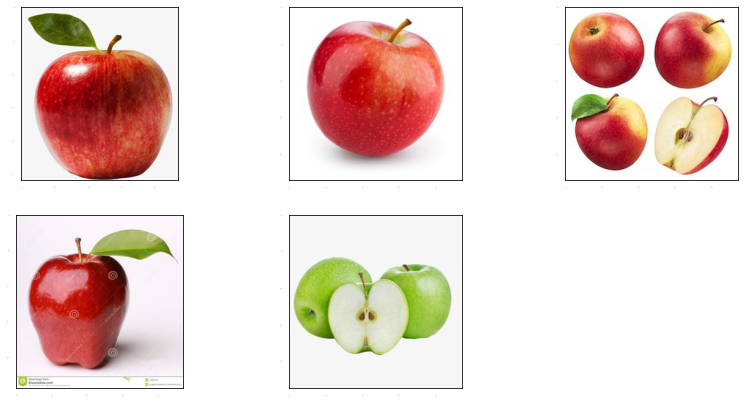

In [10]:
#load images using utility function into numpy array
images_path_list= sorted(os.listdir(train_image_dir))
print(images_path_list[0:6])

for fl in images_path_list[start:len(images_path_list)]:
  print(fl)
  image_path= os.path.join(train_image_dir, fl)
  train_images_np.append(load_image_into_numpy_array(image_path))
#for i in range(1, 6):
 # image_path = os.path.join(train_image_dir, 'robertducky' + str(i) + '.jpg')
  #train_images_np.append(load_image_into_numpy_array(image_path))

plt.rcParams['axes.grid'] = False
plt.rcParams['xtick.labelsize'] = False
plt.rcParams['ytick.labelsize'] = False
plt.rcParams['xtick.top'] = False
plt.rcParams['xtick.bottom'] = False
plt.rcParams['ytick.left'] = False
plt.rcParams['ytick.right'] = False
plt.rcParams['figure.figsize'] = [14, 7]

for idx, train_image_np in enumerate(train_images_np[1:6]):
  plt.subplot(2, 3, idx+1)
  plt.imshow(train_image_np)
plt.show()

In [11]:
print(len(train_images_np))
print(len(images_path_list))

830
830


In [12]:
print(images_path_list)

['apple10.jpg', 'apple11.jpg', 'apple12.jpg', 'apple13.jpg', 'apple4.jpg', 'apple5.jpg', 'apple6.jpg', 'apple7.jpg', 'apple8.jpg', 'apple9.jpg', 'backpack10.jpg', 'backpack11.jpg', 'backpack12.jpg', 'backpack13.jpg', 'backpack4.jpg', 'backpack5.jpg', 'backpack6.jpg', 'backpack7.jpg', 'backpack8.jpg', 'backpack9.jpg', 'ball10.jpg', 'ball11.jpg', 'ball12.jpg', 'ball13.jpg', 'ball4.jpg', 'ball5.jpg', 'ball6.jpg', 'ball7.jpg', 'ball8.jpg', 'ball9.jpg', 'banana10.jpg', 'banana11.jpg', 'banana12.jpg', 'banana13.jpg', 'banana4.jpg', 'banana5.jpg', 'banana6.jpg', 'banana7.jpg', 'banana8.jpg', 'banana9.jpg', 'basket10.jpg', 'basket11.jpg', 'basket12.jpg', 'basket13.jpg', 'basket4.jpg', 'basket5.jpg', 'basket6.jpg', 'basket7.jpg', 'basket8.jpg', 'basket9.jpg', 'bed10.jpg', 'bed11.jpg', 'bed12.jpg', 'bed13.jpg', 'bed4.jpg', 'bed5.jpg', 'bed6.jpg', 'bed7.jpg', 'bed8.jpg', 'bed9.jpg', 'bench10.jpg', 'bench11.jpg', 'bench12.jpg', 'bench13.jpg', 'bench4.jpg', 'bench5.jpg', 'bench6.jpg', 'bench7.jpg',

In [13]:
class_names= ['apple', 'bird', 'car', 'cow', 'fire', 'hat', 'mouse', 'remote', 'sofa', 'toilet', 'vase', 'backpack', 'blanket', 'cat', 'cup', 'fire_alarm', 'horse', 'orange', 'sandwich', 'spoon', 'toothbrush', 'walking_stick', 'ball', 'book', 'cell_phone', 'dining_table', 'fork', 'keyboard', 'person', 'scarf', 'stairs', 'toothpaste', 'water_purifier', 'banana', 'bottle', 'chair', 'dog', 'glass', 'knife', 'pizza', 'scissors', 'stop_sign', 'traffic_light', 'basket', 'bowl', 'chapati', 'door', 'glasses', 'laptop', 'plug', 'sheep', 'switch_board', 'trains', 'bed', 'bucket', 'charger', 'elevator_buttons', 'gloves', 'luggage', 'potholes', 'shirt', 'teddy_bear', 'trouser', 'bench', 'bus', 'clock', 'emergency_exit', 'handbag', 'microwave', 'potted_plant', 'shoes', 'television', 'trucks', 'bicycle', 'cake', 'comb', 'face_mask', 'hand_sanitiser', 'motorcycle', 'refrigerator', 'sink', 'tie', 'umbrella']
class_names= sorted(class_names)
print(class_names)

['apple', 'backpack', 'ball', 'banana', 'basket', 'bed', 'bench', 'bicycle', 'bird', 'blanket', 'book', 'bottle', 'bowl', 'bucket', 'bus', 'cake', 'car', 'cat', 'cell_phone', 'chair', 'chapati', 'charger', 'clock', 'comb', 'cow', 'cup', 'dining_table', 'dog', 'door', 'elevator_buttons', 'emergency_exit', 'face_mask', 'fire', 'fire_alarm', 'fork', 'glass', 'glasses', 'gloves', 'hand_sanitiser', 'handbag', 'hat', 'horse', 'keyboard', 'knife', 'laptop', 'luggage', 'microwave', 'motorcycle', 'mouse', 'orange', 'person', 'pizza', 'plug', 'potholes', 'potted_plant', 'refrigerator', 'remote', 'sandwich', 'scarf', 'scissors', 'sheep', 'shirt', 'shoes', 'sink', 'sofa', 'spoon', 'stairs', 'stop_sign', 'switch_board', 'teddy_bear', 'television', 'tie', 'toilet', 'toothbrush', 'toothpaste', 'traffic_light', 'trains', 'trouser', 'trucks', 'umbrella', 'vase', 'walking_stick', 'water_purifier']


In [ ]:
#occurences= {'apple':41, 'backpack':23, 'ball':11, 'banana':23, 'basket':28, 'bed':32, 'bench':42, 'bicycle':19, 'bird':22, 'blanket':32, 'book':23, 'bottle':33, 'bowl':26, 'bucket':34, 'bus':27, 'cake':10, 'car':35, 'cat':27, 'cell_phone':40, 'chair':36, 'chapati':10, 'charger':21, 'clock':35, 'comb':25, 'cow':14, 'cup':36, 'dining_table':37, 'dog':34, 'door':34, 'elevator_buttons':29, 'emergency_exit':28, 'face_mask':27, 'fire':26, 'fire_alarm':14, 'fork':24, 'glass':19 , 'glasses':10, 'gloves':31, 'hand_sanitiser':32, 'handbag':13, 'hat':32, 'horse':31, 'keyboard':42, 'knife':37, 'laptop':34, 'luggage':14, 'microwave':14, 'motorcycle':34, 'mouse':22, 'orange':29, 'person':18, 'pizza':11, 'plug':12, 'potholes':30, 'potted_plant':43, 'refrigerator':27, 'remote':25, 'sandwich':24, 'scarf':16, 'scissors':39, 'sheep':16, 'shirt':27, 'shoes':27, 'sink':22, 'sofa':28, 'spoon':36, 'stairs':42, 'stop_sign':12, 'switch_board':31, 'teddy_bear':25, 'television':17, 'tie':19, 'toilet':28, 'toothbrush':30, 'toothpaste':12, 'traffic_light':25, 'trains':28, 'trouser':12, 'trucks':28, 'umbrella':10, 'vase':11, 'walking_stick':37, 'water_purifier':37}

In [ ]:
#print(sum(list(occurences.values())))

2157


#Annotating Images

In [ ]:
'''gt_boxes = []

start=0
for i in range(0,109):
  boxes=[]
  start= start+i*20
  end= start+20
  if(end>2157):
    end= 2157
  colab_utils.annotate(train_images_np[start:end], box_storage_pointer=boxes)
  gt_boxes+boxes'''

In [ ]:
gt_boxes = []
colab_utils.annotate(train_images_np, box_storage_pointer=gt_boxes)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

'--boxes array populated--'

<IPython.core.display.Javascript object>

In [14]:
gt_boxes= np.load('/content/drive/MyDrive/Object Detection Capstone/gt_boxes.npy', allow_pickle= True)

In [17]:
print(gt_boxes)

[array([[0.17666667, 0.01694915, 0.89833333, 0.90254237]])
 array([[0.07333333, 0.02553191, 0.99833333, 1.        ]])
 array([[0.04      , 0.02118644, 0.865     , 0.94915254]])
 array([[0.49      , 0.47881356, 0.975     , 0.97457627]])
 array([[0.065     , 0.02542373, 0.9       , 0.97033898]])
 array([[0.35333333, 0.16949153, 0.85      , 0.79661017]])
 array([[0.48666667, 0.48305085, 0.86833333, 0.96186441]])
 array([[0.165     , 0.02542373, 0.86      , 0.61016949]])
 array([[0.11166667, 0.02978723, 0.98      , 1.        ]])
 array([[0.39      , 0.43220339, 0.88166667, 0.90254237]])
 array([[0.02333333, 0.08474576, 0.96      , 0.99152542]])
 array([[0.39666667, 0.28085106, 0.93166667, 0.95744681]])
 array([[0.40166667, 0.21186441, 0.97833333, 0.97881356]])
 array([[0.11333333, 0.41525424, 0.85666667, 0.99152542]])
 array([[0.13666667, 0.6059322 , 0.93833333, 0.90254237]])
 array([[0.04833333, 0.00847458, 0.96333333, 1.        ]])
 array([[0.17666667, 0.11016949, 0.72      , 0.69491525]

In [15]:
print(len(gt_boxes))

830


In [16]:
print(type(gt_boxes))

<class 'numpy.ndarray'>


In [17]:
gt_boxes= gt_boxes.tolist()
print(type(gt_boxes))

<class 'list'>


In [ ]:
np.save('gt_boxes', gt_boxes)

/usr/local/lib/python3.6/dist-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)


In [ ]:
np.save('imagesNP', train_images_np)

/usr/local/lib/python3.6/dist-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)


In [18]:
image_classes= []
for n in class_names:
  for i in range(0,10):
    image_classes.append(classes_list[n])
print(image_classes)

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 36, 36, 36, 36, 36, 36, 36, 36, 36, 36, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15,

In [19]:
print(images_path_list[130])
print(type(gt_boxes[130]))
print(gt_boxes[130])
print(gt_boxes[131])
gt_boxes.pop(130)
print(gt_boxes[130])
images_path_list.pop(130)
train_images_np.pop(130)
image_classes.pop(130)
classes_list['bucket']

bucket10.jpg
<class 'NoneType'>
None
[[0.49666667 0.68220339 0.60333333 0.82627119]]
[[0.49666667 0.68220339 0.60333333 0.82627119]]


55

In [20]:
print(images_path_list[814])

walking_stick5.jpg


In [21]:
print(type(gt_boxes[814]))

<class 'NoneType'>


In [22]:
print(gt_boxes[814])
print(gt_boxes[815])

None
[[0.08333333 0.48728814 0.95833333 0.86016949]]


In [23]:
gt_boxes.pop(814)
print(gt_boxes[814])


[[0.08333333 0.48728814 0.95833333 0.86016949]]


In [24]:
images_path_list.pop(814)
train_images_np.pop(814)
image_classes.pop(814)

22

In [25]:
classes_list['walking_stick']

22

In [26]:
# By convention, our non-background classes start counting at 1.  Given
# that we will be predicting just one class, we will therefore assign it a
# `class id` of 1.
num_classes = 83

category_index = {classes_list['apple']: {'id':classes_list['apple'] , 'name': 'apple'},
                  classes_list['bird']: {'id':classes_list['bird'] , 'name': 'bird'},
                  classes_list['car']: {'id':classes_list['car'] , 'name': 'car'},
                  classes_list['cow']: {'id':classes_list['cow'] , 'name': 'cow'},
                  classes_list['fire']: {'id':classes_list['fire'] , 'name': 'fire'},
                  classes_list['hat']: {'id':classes_list['hat'] , 'name': 'hat'},
                  classes_list['mouse']: {'id':classes_list['mouse'] , 'name': 'mouse'},
                  classes_list['remote']: {'id':classes_list['remote'] , 'name': 'remote'},
                  classes_list['sofa']: {'id':classes_list['sofa'] , 'name': 'sofa'},
                  classes_list['toilet']: {'id':classes_list['toilet'] , 'name': 'toilet'},
                  classes_list['vase']: {'id':classes_list['vase'] , 'name': 'vase'},
                  classes_list['backpack']: {'id':classes_list['backpack'] , 'name': 'backpack'},
                  classes_list['blanket']: {'id':classes_list['blanket'] , 'name': 'blanket'},
                  classes_list['cat']: {'id':classes_list['cat'] , 'name': 'cat'},
                  classes_list['cup']: {'id':classes_list['cup'] , 'name': 'cup'},
                  classes_list['fire_alarm']: {'id':classes_list['fire_alarm'] , 'name': 'fire alarm'},
                  classes_list['horse']: {'id':classes_list['horse'] , 'name': 'horse'},
                  classes_list['orange']: {'id':classes_list['orange'] , 'name': 'orange'},
                  classes_list['sandwich']: {'id':classes_list['sandwich'] , 'name': 'sandwich'},
                  classes_list['spoon']: {'id':classes_list['spoon'] , 'name': 'spoon'},
                  classes_list['toothbrush']: {'id':classes_list['toothbrush'] , 'name': 'toothbrush'},
                  classes_list['walking_stick']: {'id':classes_list['walking_stick'] , 'name': 'walking stick'},
                  classes_list['ball']: {'id':classes_list['ball'] , 'name': 'ball'},
                  classes_list['book']: {'id':classes_list['book'] , 'name': 'book'},
                  classes_list['cell_phone']: {'id':classes_list['cell_phone'] , 'name': 'cell phone'},
                  classes_list['dining_table']: {'id':classes_list['dining_table'] , 'name': 'dining table'},
                  classes_list['fork']: {'id':classes_list['fork'] , 'name': 'fork'},
                  classes_list['keyboard']: {'id':classes_list['keyboard'] , 'name': 'keyboard'},
                  classes_list['person']: {'id':classes_list['person'] , 'name': 'person'},
                  classes_list['scarf']: {'id':classes_list['scarf'] , 'name': 'scarf'},
                  classes_list['stairs']: {'id':classes_list['stairs'] , 'name': 'stairs'},
                  classes_list['toothpaste']: {'id':classes_list['toothpaste'] , 'name': 'toothpaste'},
                  classes_list['water_purifier']: {'id':classes_list['water_purifier'] , 'name': 'water purifier'},
                  classes_list['banana']: {'id':classes_list['banana'] , 'name': 'banana'},
                  classes_list['bottle']: {'id':classes_list['bottle'] , 'name': 'bottle'},
                  classes_list['chair']: {'id':classes_list['chair'] , 'name': 'chair'},
                  classes_list['dog']: {'id':classes_list['dog'] , 'name': 'dog'},
                  classes_list['glass']: {'id':classes_list['glass'] , 'name': 'glass'},
                  classes_list['knife']: {'id':classes_list['knife'] , 'name': 'knife'},
                  classes_list['pizza']: {'id':classes_list['pizza'] , 'name': 'pizza'},
                  classes_list['scissors']: {'id':classes_list['scissors'] , 'name': 'scissors'},
                  classes_list['stop_sign']: {'id':classes_list['stop_sign'] , 'name': 'stop sign'},
                  classes_list['traffic_light']: {'id':classes_list['traffic_light'] , 'name': 'traffic light'},
                  classes_list['basket']: {'id':classes_list['basket'] , 'name': 'basket'},
                  classes_list['bowl']: {'id':classes_list['bowl'] , 'name': 'bowl'},
                  classes_list['chapati']: {'id':classes_list['chapati'] , 'name': 'chapati'},
                  classes_list['door']: {'id':classes_list['door'] , 'name': 'door'},
                  classes_list['glasses']: {'id':classes_list['glasses'] , 'name': 'glasses'},
                  classes_list['laptop']: {'id':classes_list['laptop'] , 'name': 'laptop'},
                  classes_list['plug']: {'id':classes_list['plug'] , 'name': 'plug'},
                  classes_list['sheep']: {'id':classes_list['sheep'] , 'name': 'sheep'},
                  classes_list['switch_board']: {'id':classes_list['switch_board'] , 'name': 'switch board'},
                  classes_list['trains']: {'id':classes_list['trains'] , 'name': 'trains'},
                  classes_list['bed']: {'id':classes_list['bed'] , 'name': 'bed'},
                  classes_list['bucket']: {'id':classes_list['bucket'] , 'name': 'bucket'},
                  classes_list['charger']: {'id':classes_list['charger'] , 'name': 'charger'},
                  classes_list['elevator_buttons']: {'id':classes_list['elevator_buttons'] , 'name': 'elevator buttons'},
                  classes_list['gloves']: {'id':classes_list['gloves'] , 'name': 'gloves'},
                  classes_list['luggage']: {'id':classes_list['luggage'] , 'name': 'luggage'},
                  classes_list['potholes']: {'id':classes_list['potholes'] , 'name': 'potholes'},
                  classes_list['shirt']: {'id':classes_list['shirt'] , 'name': 'shirt'},
                  classes_list['teddy_bear']: {'id':classes_list['teddy_bear'] , 'name': 'teddy bear'},
                  classes_list['trouser']: {'id':classes_list['trouser'] , 'name': 'trouser'},
                  classes_list['bench']: {'id':classes_list['bench'] , 'name': 'bench'},
                  classes_list['bus']: {'id':classes_list['bus'] , 'name': 'bus'},
                  classes_list['clock']: {'id':classes_list['clock'] , 'name': 'clock'},
                  classes_list['emergency_exit']: {'id':classes_list['emergency_exit'] , 'name': 'emergency exit'},
                  classes_list['handbag']: {'id':classes_list['handbag'] , 'name': 'handbag'},
                  classes_list['microwave']: {'id':classes_list['microwave'] , 'name': 'microwave'},
                  classes_list['potted_plant']: {'id':classes_list['potted_plant'] , 'name': 'potted plant'},
                  classes_list['shoes']: {'id':classes_list['shoes'] , 'name': 'shoes'},
                  classes_list['television']: {'id':classes_list['television'] , 'name': 'television'},
                  classes_list['trucks']: {'id':classes_list['trucks'] , 'name': 'trucks'},
                  classes_list['bicycle']: {'id':classes_list['bicycle'] , 'name': 'bicycle'},
                  classes_list['cake']: {'id':classes_list['cake'] , 'name': 'cake'},
                  classes_list['comb']: {'id':classes_list['comb'] , 'name': 'comb'},
                  classes_list['face_mask']: {'id':classes_list['face_mask'] , 'name': 'face mask'},
                  classes_list['hand_sanitiser']: {'id':classes_list['hand_sanitiser'] , 'name': 'hand sanitiser'},
                  classes_list['motorcycle']: {'id':classes_list['motorcycle'] , 'name': 'motorcycle'},
                  classes_list['refrigerator']: {'id':classes_list['refrigerator'] , 'name': 'refrigerator'},
                  classes_list['sink']: {'id':classes_list['sink'] , 'name': 'sink'},
                  classes_list['tie']: {'id':classes_list['tie'] , 'name': 'tie'},
                  classes_list['umbrella']: {'id':classes_list['umbrella'] , 'name': 'umbrella'}                  
                  }



In [27]:
print(len(category_index))

83


In [28]:
# Convert class labels to one-hot; convert everything to tensors.
# The `label_id_offset` here shifts all classes by a certain number of indices;
# we do this here so that the model receives one-hot labels where non-background
# classes start counting at the zeroth index.  This is ordinarily just handled
# automatically in our training binaries, but we need to reproduce it here.
label_id_offset = 1
train_image_tensors = []
gt_classes_one_hot_tensors = []
gt_box_tensors = []
i=1
for (train_image_np, gt_box_np) in zip(
    train_images_np, gt_boxes):
  train_image_tensors.append(tf.expand_dims(tf.convert_to_tensor(
      train_image_np, dtype=tf.float32), axis=0))
  print(type(gt_box_np), i)
  i=i+1
  gt_box_tensors.append(tf.convert_to_tensor(gt_box_np, dtype=tf.float32))
  zero_indexed_groundtruth_classes = tf.convert_to_tensor(
      np.ones(shape=[gt_box_np.shape[0]], dtype=np.int32) - label_id_offset)
  gt_classes_one_hot_tensors.append(tf.one_hot(
      zero_indexed_groundtruth_classes, num_classes))
print('Done prepping data.')

<class 'numpy.ndarray'> 1
<class 'numpy.ndarray'> 2
<class 'numpy.ndarray'> 3
<class 'numpy.ndarray'> 4
<class 'numpy.ndarray'> 5
<class 'numpy.ndarray'> 6
<class 'numpy.ndarray'> 7
<class 'numpy.ndarray'> 8
<class 'numpy.ndarray'> 9
<class 'numpy.ndarray'> 10
<class 'numpy.ndarray'> 11
<class 'numpy.ndarray'> 12
<class 'numpy.ndarray'> 13
<class 'numpy.ndarray'> 14
<class 'numpy.ndarray'> 15
<class 'numpy.ndarray'> 16
<class 'numpy.ndarray'> 17
<class 'numpy.ndarray'> 18
<class 'numpy.ndarray'> 19
<class 'numpy.ndarray'> 20
<class 'numpy.ndarray'> 21
<class 'numpy.ndarray'> 22
<class 'numpy.ndarray'> 23
<class 'numpy.ndarray'> 24
<class 'numpy.ndarray'> 25
<class 'numpy.ndarray'> 26
<class 'numpy.ndarray'> 27
<class 'numpy.ndarray'> 28
<class 'numpy.ndarray'> 29
<class 'numpy.ndarray'> 30
<class 'numpy.ndarray'> 31
<class 'numpy.ndarray'> 32
<class 'numpy.ndarray'> 33
<class 'numpy.ndarray'> 34
<class 'numpy.ndarray'> 35
<class 'numpy.ndarray'> 36
<class 'numpy.ndarray'> 37
<class 'nu

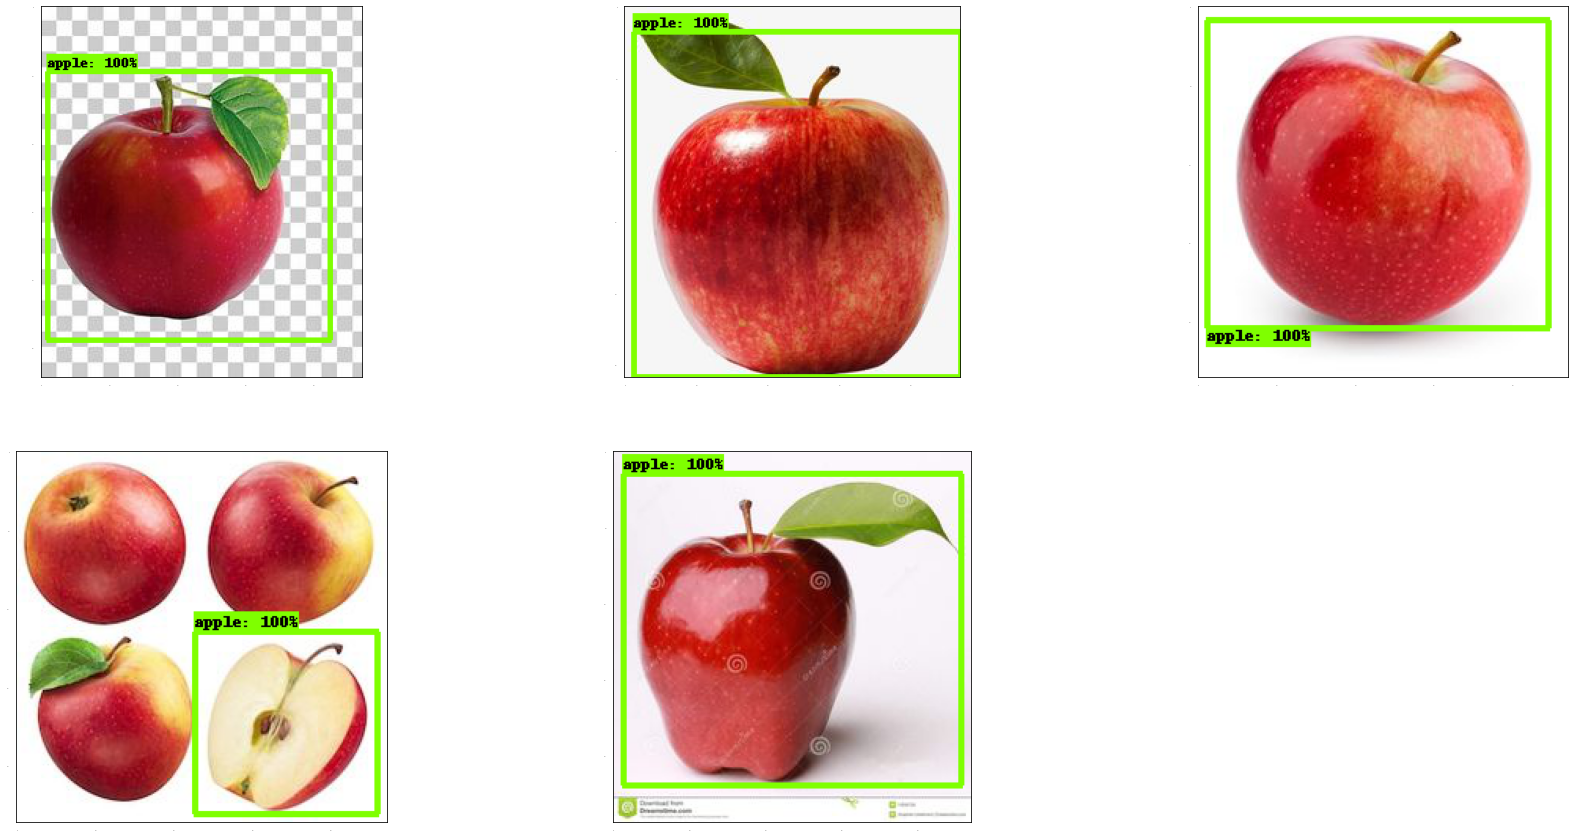

In [29]:
dummy_scores = np.array([1.0], dtype=np.float32)  # give boxes a score of 100%

plt.figure(figsize=(30, 15))
for idx in range(5):
  plt.subplot(2, 3, idx+1)
  plot_detections(
      train_images_np[idx],
      gt_boxes[idx],
      image_classes,
      dummy_scores, category_index)
plt.show()

In [30]:
# Download the checkpoint and put it into models/research/object_detection/test_data/

!wget http://download.tensorflow.org/models/object_detection/tf2/20200711/ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8.tar.gz
!tar -xf ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8.tar.gz
!if [ -d "models/research/object_detection/test_data/checkpoint" ]; then rm -Rf models/research/object_detection/test_data/checkpoint; fi
!mkdir models/research/object_detection/test_data/checkpoint
!mv ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8/checkpoint models/research/object_detection/test_data/

--2020-12-08 07:16:53--  http://download.tensorflow.org/models/object_detection/tf2/20200711/ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8.tar.gz
Resolving download.tensorflow.org (download.tensorflow.org)... 172.217.13.240, 2607:f8b0:4004:809::2010
Connecting to download.tensorflow.org (download.tensorflow.org)|172.217.13.240|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 20515344 (20M) [application/x-tar]
Saving to: ‘ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8.tar.gz.1’

ssd_mobilenet_v2_fp 100%[===================>]  19.56M  76.9MB/s    in 0.3s    

2020-12-08 07:16:54 (76.9 MB/s) - ‘ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8.tar.gz.1’ saved [20515344/20515344]



In [31]:
tf.keras.backend.clear_session()

print('Building model and restoring weights for fine-tuning...', flush=True)
num_classes = 83
pipeline_config = 'models/research/object_detection/configs/tf2/ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8.config'
checkpoint_path = 'models/research/object_detection/test_data/checkpoint/ckpt-0'

# This will be where we save checkpoint & config for TFLite conversion later.
output_directory = 'output/'
output_checkpoint_dir = os.path.join(output_directory, 'checkpoint')

# Load pipeline config and build a detection model.
#
# Since we are working off of a COCO architecture which predicts 90
# class slots by default, we override the `num_classes` field here .
configs = config_util.get_configs_from_pipeline_file(pipeline_config)
model_config = configs['model']
model_config.ssd.num_classes = num_classes
model_config.ssd.freeze_batchnorm = True
detection_model = model_builder.build(
      model_config=model_config, is_training=True)
# Save new pipeline config
pipeline_proto = config_util.create_pipeline_proto_from_configs(configs)
config_util.save_pipeline_config(pipeline_proto, output_directory)

# Set up object-based checkpoint restore --- SSD has two prediction
# `heads` --- one for classification, the other for box regression.  We will
# restore the box regression head but initialize the classification head
# from scratch (we show the omission below by commenting out the line that
# we would add if we wanted to restore both heads)
fake_box_predictor = tf.compat.v2.train.Checkpoint(
    _base_tower_layers_for_heads=detection_model._box_predictor._base_tower_layers_for_heads,
    # _prediction_heads=detection_model._box_predictor._prediction_heads,
    #    (i.e., the classification head that we *will not* restore)
    _box_prediction_head=detection_model._box_predictor._box_prediction_head,
    )
fake_model = tf.compat.v2.train.Checkpoint(
          _feature_extractor=detection_model._feature_extractor,
          _box_predictor=fake_box_predictor)
ckpt = tf.compat.v2.train.Checkpoint(model=fake_model)
ckpt.restore(checkpoint_path).expect_partial()

# To save checkpoint for TFLite conversion.
exported_ckpt = tf.compat.v2.train.Checkpoint(model=detection_model)
ckpt_manager = tf.train.CheckpointManager(
    exported_ckpt, output_checkpoint_dir, max_to_keep=1)

# Run model through a dummy image so that variables are created
image, shapes = detection_model.preprocess(tf.zeros([1, 320, 320, 3]))
prediction_dict = detection_model.predict(image, shapes)
_ = detection_model.postprocess(prediction_dict, shapes)
print('Weights restored!')

Building model and restoring weights for fine-tuning...
INFO:tensorflow:Writing pipeline config file to output/pipeline.config
Weights restored!


#Few shot Training Loop

In [32]:

# These parameters can be tuned; since our training set has 5 images
# it doesn't make sense to have a much larger batch size, though we could
# fit more examples in memory if we wanted to.
batch_size = 10
learning_rate = 0.15
num_batches = 10

# Select variables in top layers to fine-tune.
trainable_variables = detection_model.trainable_variables
to_fine_tune = []
prefixes_to_train = [
  'WeightSharedConvolutionalBoxPredictor/WeightSharedConvolutionalBoxHead',
  'WeightSharedConvolutionalBoxPredictor/WeightSharedConvolutionalClassHead']
for var in trainable_variables:
  if any([var.name.startswith(prefix) for prefix in prefixes_to_train]):
    to_fine_tune.append(var)

# Set up forward + backward pass for a single train step.
def get_model_train_step_function(model, optimizer, vars_to_fine_tune):
  """Get a tf.function for training step."""

  # Use tf.function for a bit of speed.
  # Comment out the tf.function decorator if you want the inside of the
  # function to run eagerly.
  @tf.function
  def train_step_fn(image_tensors,
                    groundtruth_boxes_list,
                    groundtruth_classes_list):
    """A single training iteration.

    Args:
      image_tensors: A list of [1, height, width, 3] Tensor of type tf.float32.
        Note that the height and width can vary across images, as they are
        reshaped within this function to be 320x320.
      groundtruth_boxes_list: A list of Tensors of shape [N_i, 4] with type
        tf.float32 representing groundtruth boxes for each image in the batch.
      groundtruth_classes_list: A list of Tensors of shape [N_i, num_classes]
        with type tf.float32 representing groundtruth boxes for each image in
        the batch.

    Returns:
      A scalar tensor representing the total loss for the input batch.
    """
    shapes = tf.constant(batch_size * [[320, 320, 3]], dtype=tf.int32)
    model.provide_groundtruth(
        groundtruth_boxes_list=groundtruth_boxes_list,
        groundtruth_classes_list=groundtruth_classes_list)
    with tf.GradientTape() as tape:
      preprocessed_images = tf.concat(
          [detection_model.preprocess(image_tensor)[0]
           for image_tensor in image_tensors], axis=0)
      prediction_dict = model.predict(preprocessed_images, shapes)
      losses_dict = model.loss(prediction_dict, shapes)
      total_loss = losses_dict['Loss/localization_loss'] + losses_dict['Loss/classification_loss']
      gradients = tape.gradient(total_loss, vars_to_fine_tune)
      optimizer.apply_gradients(zip(gradients, vars_to_fine_tune))
    return total_loss

  return train_step_fn

optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate, momentum=0.9)
train_step_fn = get_model_train_step_function(
    detection_model, optimizer, to_fine_tune)

print('Start fine-tuning!', flush=True)
for idx in range(num_batches):
  # Grab keys for a random subset of examples
  all_keys = list(range(len(train_images_np)))
  random.shuffle(all_keys)
  example_keys = all_keys[:batch_size]

  # Note that we do not do data augmentation in this demo.  If you want a
  # a fun exercise, we recommend experimenting with random horizontal flipping
  # and random cropping :)
  gt_boxes_list = [gt_box_tensors[key] for key in example_keys]
  gt_classes_list = [gt_classes_one_hot_tensors[key] for key in example_keys]
  image_tensors = [train_image_tensors[key] for key in example_keys]

  #print(len(gt_boxes_list), len(gt_classes_list), len(image_tensors))
  # Training step (forward pass + backwards pass)
  total_loss = train_step_fn(image_tensors, gt_boxes_list, gt_classes_list)

  if idx % 2 == 0:
    print('batch ' + str(idx) + ' of ' + str(num_batches)
    + ', loss=' +  str(total_loss.numpy()), flush=True)

print('Done fine-tuning!')

ckpt_manager.save()
print('Checkpoint saved!')

Start fine-tuning!
batch 0 of 10, loss=1.4020803
batch 2 of 10, loss=1.3533249
batch 4 of 10, loss=1.5058719
batch 6 of 10, loss=1.3017988
batch 8 of 10, loss=1.1866323
Done fine-tuning!
Checkpoint saved!


#Export Model

In [33]:
%%bash
python models/research/object_detection/export_tflite_graph_tf2.py \
  --pipeline_config_path output/pipeline.config \
  --trained_checkpoint_dir output/checkpoint \
  --output_directory tflite

2020-12-08 07:20:18.422270: W tensorflow/stream_executor/platform/default/dso_loader.cc:60] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/lib64-nvidia
2020-12-08 07:20:18.422308: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2020-12-08 07:20:20.687165: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2020-12-08 07:20:20.688302: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2020-12-08 07:20:20.693545: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2020-12-08 07:20:20.694133: I tensorflow/core/common_runtime/gpu/gpu_device.cc:

In [34]:
!tflite_convert --saved_model_dir=tflite/saved_model --output_file=tflite/model.tflite


2020-12-08 07:21:07.460551: W tensorflow/stream_executor/platform/default/dso_loader.cc:60] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/lib64-nvidia
2020-12-08 07:21:07.460598: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2020-12-08 07:21:09.646264: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2020-12-08 07:21:09.647361: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2020-12-08 07:21:09.652647: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2020-12-08 07:21:09.653206: I tensorflow/core/common_runtime/gpu/gpu_device.cc:

In [35]:
from google.colab import files
files.download('tflite/model.tflite')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

#Testing

In [37]:
test_image_dir = '/content/DScapstone/test/'
test_images_np = []
images_path_list_test= sorted(os.listdir(test_image_dir))
print(images_path_list_test[0:6])

for fl in images_path_list_test[50:71]:
  print(fl)
  image_path= os.path.join(test_image_dir, fl)
  test_images_np.append(np.expand_dims(
      load_image_into_numpy_array(image_path), axis=0))

#for i in range(1, 50):
 # image_path = os.path.join(test_image_dir, 'out' + str(i) + '.jpg')
 # test_images_np.append(np.expand_dims(
#      load_image_into_numpy_array(image_path), axis=0))

# Again, uncomment this decorator if you want to run inference eagerly
def detect(interpreter, input_tensor):
  """Run detection on an input image.

  Args:
    interpreter: tf.lite.Interpreter
    input_tensor: A [1, height, width, 3] Tensor of type tf.float32.
      Note that height and width can be anything since the image will be
      immediately resized according to the needs of the model within this
      function.

  Returns:
    A dict containing 3 Tensors (`detection_boxes`, `detection_classes`,
      and `detection_scores`).
  """
  input_details = interpreter.get_input_details()
  output_details = interpreter.get_output_details()

  # We use the original model for pre-processing, since the TFLite model doesn't
  # include pre-processing.
  preprocessed_image, shapes = detection_model.preprocess(input_tensor)
  interpreter.set_tensor(input_details[0]['index'], preprocessed_image.numpy())

  interpreter.invoke()

  boxes = interpreter.get_tensor(output_details[0]['index'])
  classes = interpreter.get_tensor(output_details[1]['index'])
  scores = interpreter.get_tensor(output_details[2]['index'])
  return boxes, classes, scores

# Load the TFLite model and allocate tensors.
interpreter = tf.lite.Interpreter(model_path="tflite/model.tflite")
interpreter.allocate_tensors()

# Note that the first frame will trigger tracing of the tf.function, which will
# take some time, after which inference should be fast.
label_id_offset = 1
for i in range(len(test_images_np)):
  input_tensor = tf.convert_to_tensor(test_images_np[i], dtype=tf.float32)
  boxes, classes, scores = detect(interpreter, input_tensor)

  plot_detections(
      test_images_np[i][0],
      boxes[0],
      classes[0].astype(np.uint32) + label_id_offset,
      scores[0],
      category_index, figsize=(15, 20), image_name="gif_frame_" + ('%02d' % i) + ".jpg")

['apple1.jpg', 'apple2.jpg', 'apple3.jpg', 'backpack1.jpg', 'backpack2.jpg', 'backpack3.jpg']
car3.jpg
cat1.jpg
cat2.jpg
cat3.jpg
cell_phone1.jpg
cell_phone2.jpg
cell_phone3.jpg
chair1.jpg
chair2.jpg
chair3.jpg
chapati1.jpg
chapati2.jpg
chapati3.jpg
charger1.jpg
charger2.jpg
charger3.jpg
clock1.jpg
clock2.jpg
clock3.jpg
comb1.jpg
comb2.jpg


Imageio: 'libfreeimage-3.16.0-linux64.so' was not found on your computer; downloading it now.
Try 1. Download from https://github.com/imageio/imageio-binaries/raw/master/freeimage/libfreeimage-3.16.0-linux64.so (4.6 MB)
Downloading: 8192/4830080 bytes (0.2%)3702784/4830080 bytes (76.7%)4830080/4830080 bytes (100.0%)
  Done
File saved as /root/.imageio/freeimage/libfreeimage-3.16.0-linux64.so.


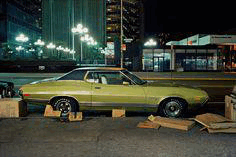

In [38]:
imageio.plugins.freeimage.download()

anim_file = 'duckies_test.gif'

filenames = glob.glob('gif_frame_*.jpg')
filenames = sorted(filenames)
last = -1
images = []
for filename in filenames:
  image = imageio.imread(filename)
  images.append(image)

imageio.mimsave(anim_file, images, 'GIF-FI', fps=5)

display(IPyImage(open(anim_file, 'rb').read()))

In [ ]:
while(True):
  pass

KeyboardInterrupt: ignored